# Introduction

Ho ho ho

References:

* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) (2015) by Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun

# Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

# Tiny ImageNet Dataset

In [3]:
datafile = '../Datasets/tiny-imagenet/tiny-imagenet-200.npz'

if not os.path.isfile(datafile):
    print('Run Tiny_ImageNet.ipynb notebook first!')
    raise

In [4]:
npzfile = np.load(datafile)
x_train_raw = npzfile['x_train']
y_train_raw = npzfile['y_train']
x_valid_raw = npzfile['x_valid']
y_valid_raw = npzfile['y_valid']
idx_to_tags = npzfile['idx_to_tags']
del npzfile  # free memory

In [5]:
x_mean = x_train_raw.mean(dtype=np.float32)
x_std = x_train_raw.std(dtype=np.float32)
x_train = (x_train_raw - x_mean) / x_std
x_valid = (x_valid_raw - x_mean) / x_std
assert x_train.dtype == np.float32
assert x_valid.dtype == np.float32
del x_train_raw
del x_valid_raw

In [6]:
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=200)
y_valid = tf.keras.utils.to_categorical(y_valid_raw, num_classes=200)
del y_train_raw
del y_valid_raw

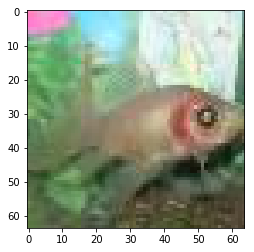

In [7]:
plt.imshow(np.int32(x_train[0]*x_std+x_mean))

# ResNet-34 Model

In [ ]:
# from tensorflow.keras.layers import Input
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Add
# from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense

# ResNet-50 Model

In [1]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense

In [5]:
def large_block(X_start, filters, name, reduce=False, res_conv2d=False):
    """
    Residual building block used by ResNet-50
    """
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]
        
    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)      # default axis-1 is ok
    X = Activation('relu')(X)
    
    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    
    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start
        
    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

In [10]:
def resnet50(input_shape, nb_classes):
    assert len(input_shape) == 3
    
    X_input = Input(shape=input_shape)

    # conv1
#     X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1')(X_input)
#     X = BatchNormalization(name='bn_conv1')(X)
#     X = Activation('relu')(X)
#     X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv1 - alternative
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[1,1], padding='valid', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    # X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = large_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = large_block(X, filters=[64, 64, 256], name='conv2_b')
    X = large_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = large_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = large_block(X, filters=[128, 128, 512], name='conv3_b')
    X = large_block(X, filters=[128, 128, 512], name='conv3_c')
    X = large_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = large_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = large_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = large_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = large_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = large_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = large_block(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = large_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = large_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = large_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=nb_classes, activation='softmax')(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
model = resnet50(input_shape=[64, 64, 3], nb_classes=200)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 58, 58, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 58, 58, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_97 (Activation)      (None, 58, 58, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
conv2_a (C

In [11]:
model = resnet50(input_shape=[64, 64, 3], nb_classes=200)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [12]:
vloss, vacc = model.evaluate(x_valid, y_valid, batch_size=250)
print(f'loss: {vloss:5.3f}     acc: {100*vacc:4.1f}%')

10000/10000 [==============================] - 6s 577us/step
loss: 5.300     acc:  0.5%


In [ ]:
hist = model.fit(x=x_train, y=y_train, batch_size=250, epochs=1,
                 validation_data=(x_valid, y_valid))

In [ ]:
hist2 = model.fit(x=x_train, y=y_train, batch_size=250, epochs=1,
                 validation_data=(x_valid, y_valid))

In [ ]:
hist3 = model.fit(x=x_train, y=y_train, batch_size=250, epochs=8,
                 validation_data=(x_valid, y_valid))

In [ ]:
hist4 = model.fit(x=x_train, y=y_train, batch_size=250, epochs=10,
                 validation_data=(x_valid, y_valid))

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator(
    rotation_range=20,       # random rotation degrees
    width_shift_range=0.1,   # random shift 10%
    height_shift_range=0.1,
    horizontal_flip=True)

In [ ]:
import time
ts = time.time()
for i, (x_batch, y_batch) in enumerate(img_data_gen.flow(x_train, y_train, batch_size=250)):
    if i >= 250:
        break
print(time.time() - ts)

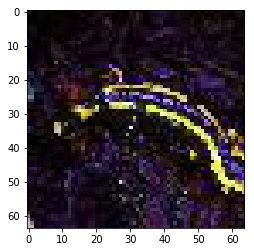

In [30]:
index = 743
plt.imshow( np.int32(x_train[index] * x_std + x_mean) );
plt.show()

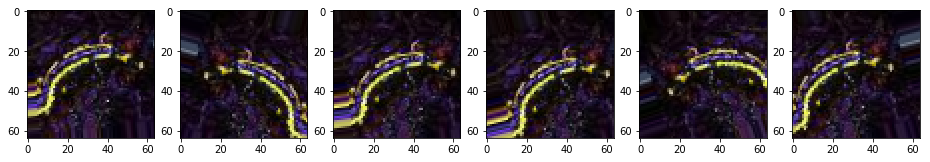

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i, x_batch in enumerate(img_data_gen.flow(x_train[index:index+1], batch_size=1)):
    axes[i].imshow( np.int32(x_batch[0] * x_std + x_mean))
    if i >= len(axes)-1:
        break

In [33]:
hist = model.fit_generator(generator=img_data_gen.flow(x_train, y_train, batch_size=100),
                           validation_data=(x_valid, y_valid),
                           steps_per_epoch=len(x_train)/100, epochs=20)

Epoch 1/20
1000/1000 [==============================] - 168s 168ms/step - loss: 5.0597 - acc: 0.0345 - val_loss: 7.8915 - val_acc: 0.0106
Epoch 2/20
1000/1000 [==============================] - 149s 149ms/step - loss: 4.7884 - acc: 0.0643 - val_loss: 4.7993 - val_acc: 0.0462
Epoch 3/20
 245/1000 [======>.......................] - ETA: 1:50 - loss: 4.9705 - acc: 0.0424

KeyboardInterrupt: 

In [34]:
vloss, vacc = model.evaluate(x_valid, y_valid, batch_size=100)
print(f'loss: {vloss:5.3f}     acc: {100*vacc:4.1f}%')

10000/10000 [==============================] - 4s 378us/step
loss: 4.955     acc:  4.1%
